In [1]:
from src.model import VAE
from src.trainer import CDVAETrainer
from src.utils import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [4]:
np.random.seed(101)
torch.manual_seed(101)

In [5]:
from src.utils import StyledMNISTGenerator, StyledMNIST

generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3934.84item/s]


In [6]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [1e2, 1e2]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [7]:
trainer.fit(81, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 98.70it/s] 


val_recontr_loss=61.528, val_kl_c=10.462, val_kl_s=14.268, val_c_loss=0.269, val_s_loss=0.109
gMIG: 0.186; elbo: -86.259


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 186.41it/s]


val_recontr_loss=32.543, val_kl_c=12.110, val_kl_s=18.426, val_c_loss=0.123, val_s_loss=0.111
gMIG: 0.243; elbo: -63.079


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 173.68it/s]


val_recontr_loss=25.160, val_kl_c=13.545, val_kl_s=19.913, val_c_loss=0.112, val_s_loss=0.110
gMIG: 0.257; elbo: -58.618


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 242.96it/s]


val_recontr_loss=22.354, val_kl_c=13.542, val_kl_s=19.849, val_c_loss=0.095, val_s_loss=0.110
gMIG: 0.264; elbo: -55.745


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 242.51it/s]


val_recontr_loss=20.482, val_kl_c=14.364, val_kl_s=20.280, val_c_loss=0.083, val_s_loss=0.110
gMIG: 0.276; elbo: -55.126


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 256.48it/s]


val_recontr_loss=19.444, val_kl_c=15.183, val_kl_s=21.094, val_c_loss=0.089, val_s_loss=0.110
gMIG: 0.275; elbo: -55.721


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 248.00it/s]


val_recontr_loss=18.377, val_kl_c=15.389, val_kl_s=20.309, val_c_loss=0.087, val_s_loss=0.110
gMIG: 0.279; elbo: -54.076


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 245.40it/s]


val_recontr_loss=17.431, val_kl_c=15.784, val_kl_s=21.393, val_c_loss=0.081, val_s_loss=0.109
gMIG: 0.284; elbo: -54.608


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 239.79it/s]


val_recontr_loss=17.235, val_kl_c=15.829, val_kl_s=21.154, val_c_loss=0.086, val_s_loss=0.109
gMIG: 0.288; elbo: -54.218


val-epoch 45: 100%|██████████| 79/79 [00:00<00:00, 226.76it/s]


val_recontr_loss=16.720, val_kl_c=15.735, val_kl_s=21.229, val_c_loss=0.082, val_s_loss=0.109
gMIG: 0.285; elbo: -53.685


val-epoch 50: 100%|██████████| 79/79 [00:00<00:00, 233.42it/s]


val_recontr_loss=16.475, val_kl_c=15.974, val_kl_s=21.108, val_c_loss=0.081, val_s_loss=0.109
gMIG: 0.29; elbo: -53.557


val-epoch 55: 100%|██████████| 79/79 [00:00<00:00, 230.95it/s]


val_recontr_loss=16.033, val_kl_c=16.017, val_kl_s=21.443, val_c_loss=0.081, val_s_loss=0.109
gMIG: 0.286; elbo: -53.493


val-epoch 60: 100%|██████████| 79/79 [00:00<00:00, 220.45it/s]


val_recontr_loss=15.794, val_kl_c=16.259, val_kl_s=20.715, val_c_loss=0.081, val_s_loss=0.110
gMIG: 0.291; elbo: -52.768


val-epoch 65: 100%|██████████| 79/79 [00:00<00:00, 230.61it/s]


val_recontr_loss=15.608, val_kl_c=16.408, val_kl_s=21.979, val_c_loss=0.081, val_s_loss=0.109
gMIG: 0.288; elbo: -53.995


val-epoch 70: 100%|██████████| 79/79 [00:00<00:00, 235.82it/s]


val_recontr_loss=15.923, val_kl_c=16.237, val_kl_s=21.309, val_c_loss=0.086, val_s_loss=0.109
gMIG: 0.292; elbo: -53.469


val-epoch 75: 100%|██████████| 79/79 [00:00<00:00, 233.73it/s]


val_recontr_loss=15.251, val_kl_c=16.419, val_kl_s=21.249, val_c_loss=0.080, val_s_loss=0.109
gMIG: 0.292; elbo: -52.919


val-epoch 80: 100%|██████████| 79/79 [00:00<00:00, 240.11it/s]


val_recontr_loss=15.092, val_kl_c=16.560, val_kl_s=20.737, val_c_loss=0.082, val_s_loss=0.110
gMIG: 0.291; elbo: -52.389


In [8]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)


In [9]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
c_idx_dict

{0: tensor([ 45,  50,  71,  88,  94,  97, 100, 105, 108, 118, 120]),
 1: tensor([  0,   3,  23,  35,  37,  59,  61,  65,  81,  85,  87,  98, 112, 114]),
 2: tensor([  2,  11,  15,  17,  18,  19,  31,  47,  51,  63,  76,  80,  89,  99,
         109, 116, 119, 121]),
 3: tensor([  5,   6,  12,  29,  38,  43,  56,  64,  69,  75,  77,  79,  90, 106]),
 4: tensor([  1,  10,  14,  20,  24,  30,  40,  44,  48,  57,  83,  95, 113, 117,
         122, 123]),
 5: tensor([ 16,  21,  22,  33,  41,  91, 103, 124]),
 6: tensor([  9,  25,  32,  36,  46,  49,  54,  62,  66,  72,  74,  78,  82,  92,
         115, 125]),
 7: tensor([  4,   8,  26,  28,  42,  52,  53,  58,  70,  84,  86, 101, 104]),
 8: tensor([ 34,  39,  55,  60,  68,  93,  96, 107, 111, 126]),
 9: tensor([  7,  13,  27,  67,  73, 102, 110, 127])}

In [10]:
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]
s_idx_dict

{0: tensor([ 31,  37,  41,  54,  56,  77,  87, 105, 126]),
 1: tensor([ 22,  38,  44,  46,  57,  62,  68,  75,  80,  81,  85,  86,  89,  93,
         106, 107, 112, 113, 114, 120, 121, 127]),
 2: tensor([  1,   3,  10,  11,  12,  13,  20,  27,  32,  33,  34,  36,  43,  47,
          50,  58,  63,  65,  72,  73,  74,  76,  78,  82,  90,  91,  94,  95,
          97,  98, 103, 118, 119]),
 3: tensor([  4,   6,  17,  23,  25,  29,  39,  40,  48,  61,  66,  67,  79,  88,
          92,  96, 108, 115, 116, 117]),
 4: tensor([  0,   8,  16,  19,  21,  30,  35,  53,  55,  69,  71,  83,  84, 104,
         110, 111, 123, 124]),
 5: tensor([  2,   5,   7,   9,  14,  15,  18,  24,  26,  28,  42,  45,  49,  51,
          52,  59,  60,  64,  70,  99, 100, 101, 102, 109, 122, 125])}

In [17]:
# illustration using all s
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape

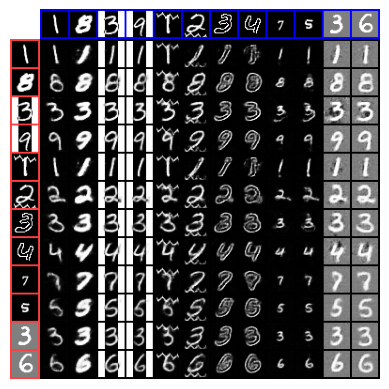

In [19]:
from expr.visual_util import feature_swapping_plot

feature_swapping_plot(z_c, z_s, X[img_idx], vae)

In [24]:
# illustration using all c
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape


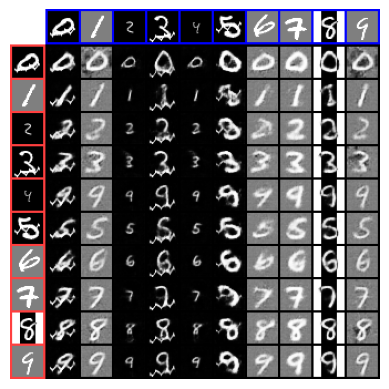

In [25]:
feature_swapping_plot(z_c, z_s, X[img_idx], vae)